# Least Squares GAN

In [1]:
import tensorflow as tf
import numpy as np

# Download & Load MNIST Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def fully_connected_layer(x, input_size, output_size, initializer=tf.random_uniform_initializer(), activation=tf.nn.relu, count=0):
    w = tf.get_variable('w' + str(count), [input_size, output_size], initializer=initializer)
    b = tf.get_variable('b' + str(count), [output_size], initializer=tf.constant_initializer(1.0), dtype=tf.float32, trainable=True)
    
    print(w.name, b.name)
    
    l = tf.nn.bias_add(tf.matmul(x, w), b)
    
    return activation(l), l, w, b


In [5]:
class ModelMaker(object):
    def __init__(self, layer_sizes):
        # Fully Connected Layers
        self.fcl_sizes = layer_sizes

        
    def create_layers(self, x, initializer=tf.truncated_normal_initializer, initializer_params={'dtype': tf.float32, 'stddev': 1e-1},\
                      name='noname', reuse=False):
        if not reuse:
            self.parameters = []

        last_layer = x
        last_size = int(np.prod(last_layer.get_shape()[1:]))

        with tf.variable_scope(name, reuse=reuse) as scope:
            # Generate Dense Layer
            for layer_count, ((layer_size, param_dict), dropout_use, constant_dropout, dropout_rate) in enumerate(self.fcl_sizes):
                last_layer, l, w, b = fully_connected_layer(x=last_layer, \
                                                            input_size=int(last_layer.get_shape()[1]), output_size=layer_size, \
                                                            initializer=initializer(**initializer_params), count=layer_count, **param_dict)
                
                if not reuse:
                    self.parameters = self.parameters + [w, b]

                if dropout_use:
                    if constant_dropout:
                        last_layer = tf.nn.dropout(last_layer, dropout_rate)
                    else:
                        last_layer = tf.nn.dropout(last_layer, self.dropout_rates[dropout_rate])

                        
                setattr(self, 'dense_%d_%s' % (layer_count+1, name), last_layer)

        self.last_layer = last_layer

In [6]:
# Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
def LeakyReLU(x, leak=0.2, name='LeakyReLU'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
from PIL import Image
def ArrayToImage(arr):
    
    size = np.sqrt(arr.shape[0]).astype(int)
    arr = arr.reshape(size, size)
    
    img = Image.fromarray(np.uint8(arr))
    return img

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import time

def DisplayHorizontal(images, header=None, width="100%", figsize=(20, 20), fontsize=20, depth=1):
    num_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        image = images[i]
        
        fig.add_subplot(depth, num_images/depth, i+1)
        plt.axis('off')
        if header != None:
            plt.title(header[i], fontsize=fontsize)
        plt.imshow(image, cmap='Greys_r', interpolation='nearest')

# Implement Option

In [8]:
z_var_dim = 100

img_size = 784

generator_layer_shape = (
    ((128, {}), False, None, None),
    ((256, {}), False, None, None),
    ((img_size, {'activation': tf.nn.tanh}), False, None, None),
)

discriminator_layer_shape = (
    ((256, {'activation': LeakyReLU}), False, None, None),
    ((128, {'activation': LeakyReLU}), False, None, None),
    ((1, {'activation': tf.nn.sigmoid}), False, None, None),
)

### Train Option

In [9]:
epoch_size = 1000
batch_size = 512
d_train_epoch = 2
g_train_epoch = 1

# Implement Variable & Model

In [10]:
with tf.device('/gpu:0'):            
    G = ModelMaker(generator_layer_shape)
    D = ModelMaker(discriminator_layer_shape)
        
    Z = tf.placeholder(tf.float32, [None, z_var_dim])
    
    G.create_layers(Z, name='Generator')
    X_Fake = G.last_layer    
    D.create_layers(X_Fake, name='Discriminator')
    Y_Fake = D.last_layer
    
    X_Real = tf.placeholder(tf.float32, [None, img_size])    
    D.create_layers(X_Real, name='Discriminator', reuse=True)
    Y_Real = D.last_layer
                
    # Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
    # Least Square GAN Loss
    loss_D = 0.5 * (tf.square(Y_Real-1) + tf.square(Y_Fake))
    loss_G = 0.5 * (tf.square(Y_Fake-1))
    Optimizer_D = tf.train.AdamOptimizer(learning_rate=8e-5, beta1=5e-1)
    Optimizer_G = tf.train.AdamOptimizer(learning_rate=8e-5, beta1=5e-1)
    
    Param_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
    Param_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
    
    Grad_D = Optimizer_D.compute_gradients(loss_D, Param_D)
    Grad_G = Optimizer_G.compute_gradients(loss_G, Param_G)
    
    Train_D = Optimizer_D.apply_gradients(Grad_D)
    Train_G = Optimizer_G.apply_gradients(Grad_G)

Generator/w0:0 Generator/b0:0
Generator/w1:0 Generator/b1:0
Generator/w2:0 Generator/b2:0
Discriminator/w0:0 Discriminator/b0:0
Discriminator/w1:0 Discriminator/b1:0
Discriminator/w2:0 Discriminator/b2:0
Discriminator/w0:0 Discriminator/b0:0
Discriminator/w1:0 Discriminator/b1:0
Discriminator/w2:0 Discriminator/b2:0


# Train & Show Result

In [11]:
z_sample = np.random.normal(0, 1, size=(10, z_var_dim)).astype(np.float32)

In [12]:
display_epoch = 5

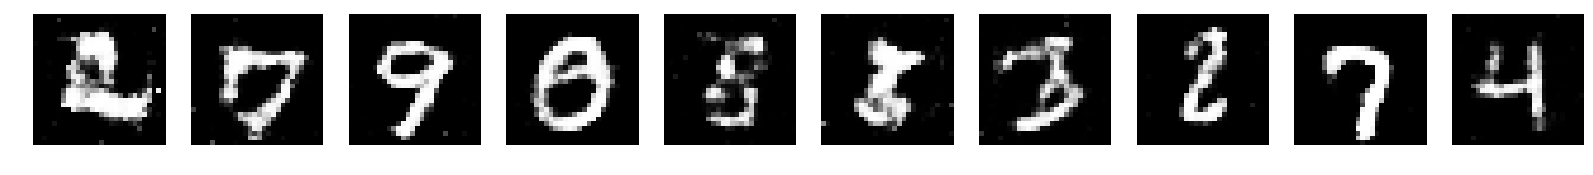

Epoch : 996, loss_d : 0.1593, loss_g : 0.2114
Epoch : 997, loss_d : 0.1590, loss_g : 0.2117
Epoch : 998, loss_d : 0.1582, loss_g : 0.2131
Epoch : 999, loss_d : 0.1580, loss_g : 0.2135


In [13]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)))

tf.global_variables_initializer().run(session=sess)

for i in range(epoch_size):
    ld = 0
    lg = 0
    
    count = int(mnist.train.num_examples / batch_size)
    for j in range(count):
        batch_train, _ = mnist.train.next_batch(batch_size)
        batch_train = batch_train.astype(np.float32) * 2 - 1
        batch_z = np.random.normal(0, 1, size=(batch_size, z_var_dim)).astype(np.float32)

        # Discriminator Train
        for _ in range(d_train_epoch):
            _, loss_d = sess.run([Train_D, loss_D], feed_dict={X_Real: batch_train, Z: batch_z})
            ld += np.mean(loss_d) / (count * d_train_epoch)

        # Generator Train
        for _ in range(g_train_epoch):
            _, loss_g = sess.run([Train_G, loss_G], feed_dict={X_Real: batch_train, Z: batch_z})
            lg += np.mean(loss_g) / (count * g_train_epoch)
            
    print('Epoch : %d, loss_d : %.4f, loss_g : %.4f' % (i, ld, lg))
    
    gen_mnist = sess.run(X_Fake, feed_dict={Z: z_sample})
    if i % display_epoch == 0:
        display.clear_output(wait=True)
        DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist])
        display.display(plt.gcf())
        plt.close()

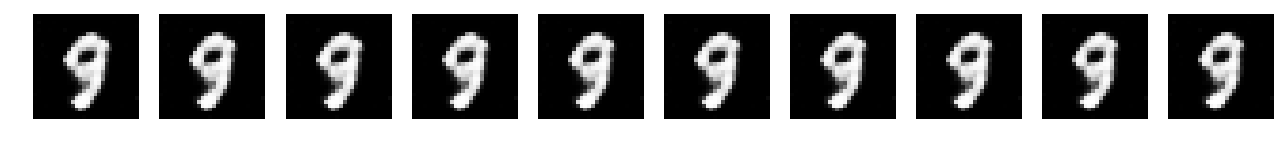

In [14]:
new_z_sample = np.zeros([10, z_var_dim])
for i in range(10):
    new_z_sample[i][0] = 0.1 * i

gen_mnist = sess.run(X_Fake, feed_dict={Z: new_z_sample})
DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist], depth=1, figsize=(16, 4*2))
display.display(plt.gcf())